In [18]:
# ==============================================================================
# Notebook 4 (v2): Simulação de Novos Clientes, Comparação e Conclusão
# ==============================================================================

# ------------------------------------------------------------------------------
# 1. Configuração e Carregamento de Bibliotecas e Artefatos
# ------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import joblib
import os
import json
import shap
import matplotlib.pyplot as plt

In [23]:
# --- Definindo os caminhos conforme a estrutura de diretórios ---
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

FINAL_MODEL_V1_PATH = os.path.join(ROOT_DIR, 'models', 'final_model', 'random_forest_final.pkl')
FINAL_MODEL_V2_PATH = os.path.join(ROOT_DIR, 'models', 'final_model_v2', 'random_forest_final_v2.pkl')
PREPROCESSING_PATH = os.path.join(ROOT_DIR, 'models', 'preprocessing')
REPORTS_PATH = os.path.join(ROOT_DIR, 'reports')
REPORTS_V2_PATH = os.path.join(ROOT_DIR, 'reports', 'v2')
PLOTS_V2_PATH = os.path.join(ROOT_DIR, 'reports', 'v2', 'plots')
X_TRAIN_PATH = os.path.join(ROOT_DIR, 'data', 'processed', 'split', 'X_train.csv')

# --- Definindo o diretório e os caminhos dos arquivos separadamente ---
FINAL_MODEL_V2_DIR = os.path.join(ROOT_DIR, 'models', 'final_model_v2')
FINAL_MODEL_V2_PATH = os.path.join(FINAL_MODEL_V2_DIR, 'random_forest_final_v2.pkl')
SHAP_EXPLAINER_V2_PATH = os.path.join(FINAL_MODEL_V2_DIR, 'shap_explainer_v2.pkl')

In [25]:
# Carregando artefatos da versão 1
try:
    final_model_v1 = joblib.load(FINAL_MODEL_V1_PATH)
    metrics_v1_path = os.path.join(REPORTS_PATH, 'final_model_metrics.json')
    with open(metrics_v1_path, 'r') as f:
        metrics_v1 = json.load(f)
    print("✅ Artefatos da versão 1 carregados.")
except FileNotFoundError as e:
    print(f"❌ Erro ao carregar artefatos da v1: {e}. Certifique-se de que o notebook 3 original foi executado.")
    final_model_v1, metrics_v1 = None, None

# Carregando artefatos da versão 2
try:
    final_model_v2 = joblib.load(FINAL_MODEL_V2_PATH)
    scaler = joblib.load(os.path.join(PREPROCESSING_PATH, 'standard_scaler.pkl'))
    label_encoder_churn = joblib.load(os.path.join(PREPROCESSING_PATH, 'label_encoder_churn.pkl'))
    
    # --- CORREÇÃO APLICADA AQUI ---
    explainer_v2 = joblib.load(SHAP_EXPLAINER_V2_PATH)

    metrics_v2_path = os.path.join(REPORTS_V2_PATH, 'final_model_metrics_v2.json')
    with open(metrics_v2_path, 'r') as f:
        metrics_v2 = json.load(f)
    X_train = pd.read_csv(X_TRAIN_PATH)
    print("✅ Artefatos da versão 2 e de pré-processamento carregados.")
except FileNotFoundError as e:
    print(f"❌ Erro ao carregar artefatos da v2: {e}. Certifique-se de que o novo notebook 3 foi executado.")
    final_model_v2, scaler, label_encoder_churn, explainer_v2, metrics_v2, X_train = [None] * 6

✅ Artefatos da versão 1 carregados.
✅ Artefatos da versão 2 e de pré-processamento carregados.


In [26]:
if final_model_v2 is not None:
    # ------------------------------------------------------------------------------
    # 2. Simulação de Novos Dados
    # ------------------------------------------------------------------------------
    print("\nSimulando novos dados de clientes e fazendo previsões com a versão 2...")
    
    new_customers_data = {
        'gender': ['Female', 'Male'],
        'SeniorCitizen': [0, 1],
        'Partner': ['Yes', 'No'],
        'Dependents': ['Yes', 'No'],
        'tenure': [12, 1],
        'PhoneService': ['Yes', 'Yes'],
        'MultipleLines': ['Yes', 'No'],
        'InternetService': ['Fiber optic', 'DSL'],
        'OnlineSecurity': ['No', 'No'],
        'OnlineBackup': ['Yes', 'No'],
        'DeviceProtection': ['No', 'No'],
        'TechSupport': ['No', 'No'],
        'StreamingTV': ['Yes', 'No'],
        'StreamingMovies': ['Yes', 'No'],
        'Contract': ['Month-to-month', 'Month-to-month'],
        'PaperlessBilling': ['Yes', 'No'],
        'PaymentMethod': ['Electronic check', 'Mailed check'],
        'MonthlyCharges': [89.0, 45.0],
        'TotalCharges': [1068.0, 45.0]
    }
    
    new_customers_df = pd.DataFrame(new_customers_data)


Simulando novos dados de clientes e fazendo previsões com a versão 2...


In [27]:
# Pré-processamento
new_customers_df['gender'] = new_customers_df['gender'].map({'Female': 0, 'Male': 1})
new_customers_df['Partner'] = new_customers_df['Partner'].map({'No': 0, 'Yes': 1})
new_customers_df['Dependents'] = new_customers_df['Dependents'].map({'No': 0, 'Yes': 1})
new_customers_df['PhoneService'] = new_customers_df['PhoneService'].map({'No': 0, 'Yes': 1})
new_customers_df['PaperlessBilling'] = new_customers_df['PaperlessBilling'].map({'No': 0, 'Yes': 1})
    
new_customers_df = pd.get_dummies(new_customers_df, columns=[
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaymentMethod', 'InternetService'
], drop_first=True)
    
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
new_customers_df[numeric_cols] = scaler.transform(new_customers_df[numeric_cols])
    
new_customers_aligned = new_customers_df.reindex(columns=X_train.columns, fill_value=0)

In [28]:
# Previsão
churn_probabilities = final_model_v2.predict_proba(new_customers_aligned)[:, 1]
optimized_threshold = metrics_v2['best_threshold']
churn_predictions = (churn_probabilities >= optimized_threshold).astype(int)

new_customers_df['Probability of Churn'] = churn_probabilities
new_customers_df['Predicted Churn'] = label_encoder_churn.inverse_transform(churn_predictions)
    
print("✅ Previsões realizadas com sucesso com a versão 2.")
print("\nResultados da Simulação:")
print(new_customers_df[['Probability of Churn', 'Predicted Churn']])

✅ Previsões realizadas com sucesso com a versão 2.

Resultados da Simulação:
   Probability of Churn Predicted Churn
0              0.820000             Yes
1              0.726667             Yes



--- Análise de Interpretabilidade (SHAP) para os Clientes Simulados ---

Explicação da Previsão para o Cliente #1:


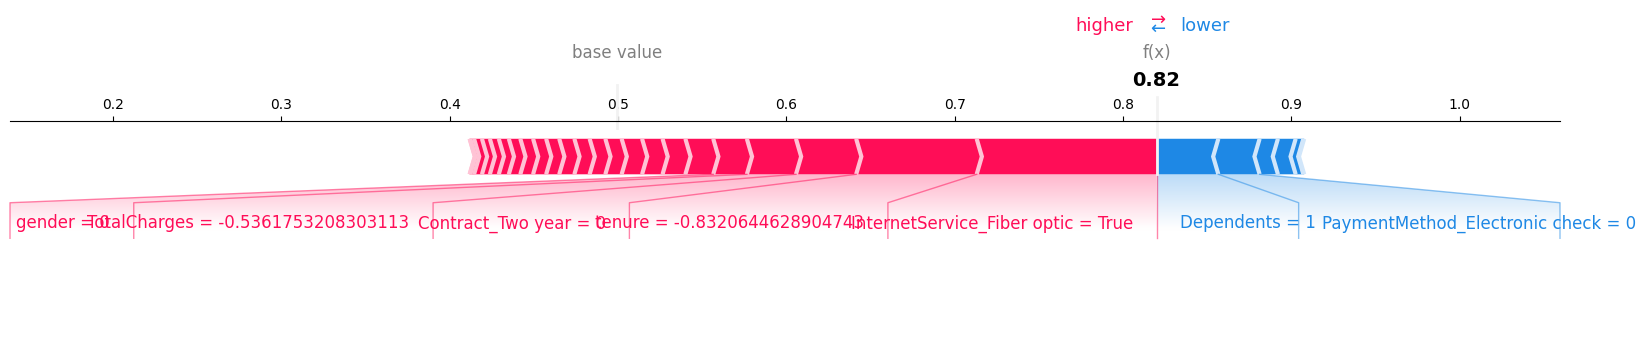


Explicação da Previsão para o Cliente #2:


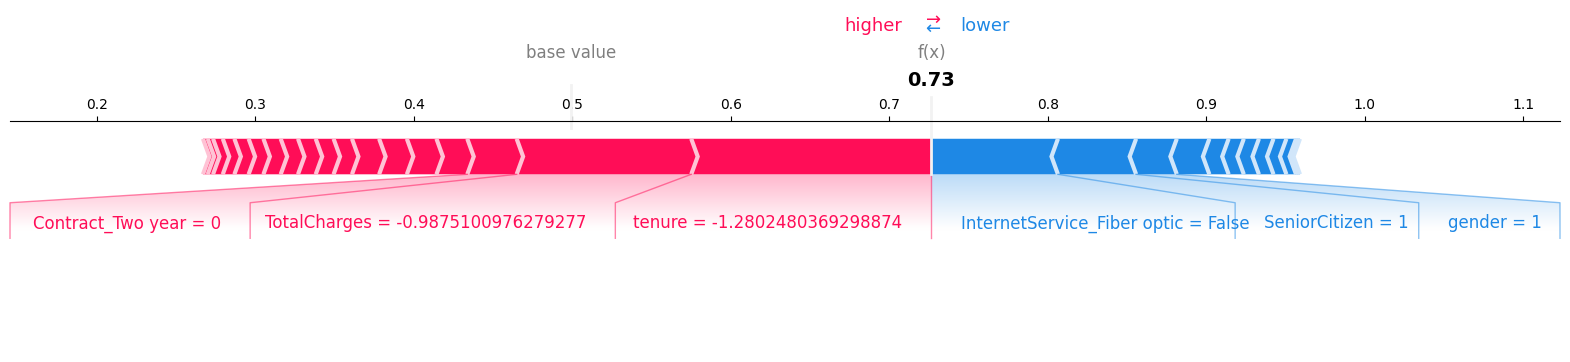

In [30]:
# ------------------------------------------------------------------------------
# 3. Análise SHAP para a Simulação (Versão Robustecida)
# ------------------------------------------------------------------------------
print("\n--- Análise de Interpretabilidade (SHAP) para os Clientes Simulados ---")
    
try:
    simulated_shap_values = explainer_v2.shap_values(new_customers_aligned)
        
    if isinstance(simulated_shap_values, list):
        shap_values_plot = simulated_shap_values[1]
    elif len(simulated_shap_values.shape) == 3:
        shap_values_plot = simulated_shap_values[:,:,1]
    else:
        shap_values_plot = simulated_shap_values
            
    if shap_values_plot.shape[1] != new_customers_aligned.shape[1]:
        print("Ajustando dimensões dos SHAP values para a simulação...")
        min_features = min(shap_values_plot.shape[1], new_customers_aligned.shape[1])
        shap_values_plot = shap_values_plot[:, :min_features]
        new_customers_aligned_plot = new_customers_aligned.iloc[:, :min_features]
    else:
        new_customers_aligned_plot = new_customers_aligned
        
    for i, row in new_customers_aligned_plot.iterrows():
        print(f"\nExplicação da Previsão para o Cliente #{i+1}:")
        shap.initjs()
            
        display(shap.force_plot(
            explainer_v2.expected_value[1], 
            shap_values_plot[i], 
            row, 
            show=False, 
            matplotlib=True
        ))
            
        plt.tight_layout()
        plot_path = os.path.join(PLOTS_V2_PATH, f'shap_force_plot_cliente_{i+1}.png')
        plt.savefig(plot_path, bbox_inches='tight', dpi=300)
        plt.close()

except Exception as e:
    print(f"\n❌ ERRO NA INTERPRETAÇÃO SHAP para a simulação: {str(e)}")
    print("Verifique se o `explainer_v2` foi salvo corretamente e se os dados de entrada estão no formato correto.")
   

In [32]:
# ------------------------------------------------------------------------------
# 4. Comparação de Resultados e Conclusão
# ------------------------------------------------------------------------------
print("\n--- Conclusão do Projeto (Comparação V1 vs. V2) ---")
    
if final_model_v1 is not None:
    comparison_metrics = pd.DataFrame({
        'Métrica': ['Precisão', 'Recall', 'F1-Score', 'AUC'],
        'Modelo Otimizado (V1)': [
            metrics_v1['precision'],
            metrics_v1['recall'],
            metrics_v1['f1-score'],
            metrics_v1['auc_score']
        ],
        'Modelo Otimizado (V2)': [
            metrics_v2['precision'],
            metrics_v2['recall'],
            metrics_v2['f1-score'],
            metrics_v2['auc_score']
        ]
    })
    print("Comparação de Métricas de Desempenho:")
    print(comparison_metrics)
    
print("\n✅ Processo do Notebook 4 (v2) concluído com sucesso!")


--- Conclusão do Projeto (Comparação V1 vs. V2) ---
Comparação de Métricas de Desempenho:
    Métrica  Modelo Otimizado (V1)  Modelo Otimizado (V2)
0  Precisão               0.702133               0.702791
1    Recall               0.754783               0.755675
2  F1-Score               0.702134               0.702745
3       AUC               0.819362               0.818344

✅ Processo do Notebook 4 (v2) concluído com sucesso!
